# Process droughts and pluvials for SWNA Soil Moisture from each PHYDA Ensemble Member 

### Start Clean

In [36]:
# Reset the environment (start clean)
%reset -f

# Import Modules and define functions
import calendar
import datetime
import os
import numpy as np
import numpy.ma as ma
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import scipy.io as sio
import seaborn as sns
import pandas as pd
import scipy.stats as stats
#import statsmodels.api as sm
from IPython.display import display
import IPython
import requests
import pandas as pd
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf 
import matplotlib.colors as colors

# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Borders for mapping: Cultural borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
# Coastline
newcoast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k',
                                        facecolor='none')
#Lakes
newlake = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                        facecolor='none')

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For asymetric colorbars
# https://matplotlib.org/stable/tutorials/colors/colormapnorms.html?highlight=twoslopenorm#twoslopenorm-different-mapping-on-either-side-of-a-center
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# For plotting a rectangle on the maps
def plot_rectangle(ax, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    ax.plot(xs,ys,color='k',linestyle='--',linewidth=3,transform=ccrs.PlateCarree())

# For plotting a point on a map
def plot_point(ax,lon,lat):
    xs = [lon]
    ys = [lat]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    #ax.scatter(xs,ys,color=np.array([0.5,0.5,0.5]),marker='*',linewidth=3,transform=ccrs.PlateCarree())
    ax.scatter(xs,ys,color='k',edgecolors='k',marker='+',linewidth=0.5,s=5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.5)

ocean_color = np.float64([209,230,241])/255
nmap=plt.get_cmap(name=plt.cm.BrBG,lut=12) # only needed to set bins for pcolor/pcolormesh
      
# Month Vector
mons     = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Set plot styles
# Formatting for titles
fontdict_title = {'fontsize': 36}
fig_size = np.array([10,10])

# Formatting for figures
style_new = {'xtick.direction': 'in', \
             'ytick.direction': 'in', \
             'font.sans-serif': 'Arial'}


## Function for Finding Consecutive Values

In [37]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result


## Process Running Means and Plot SM-REC

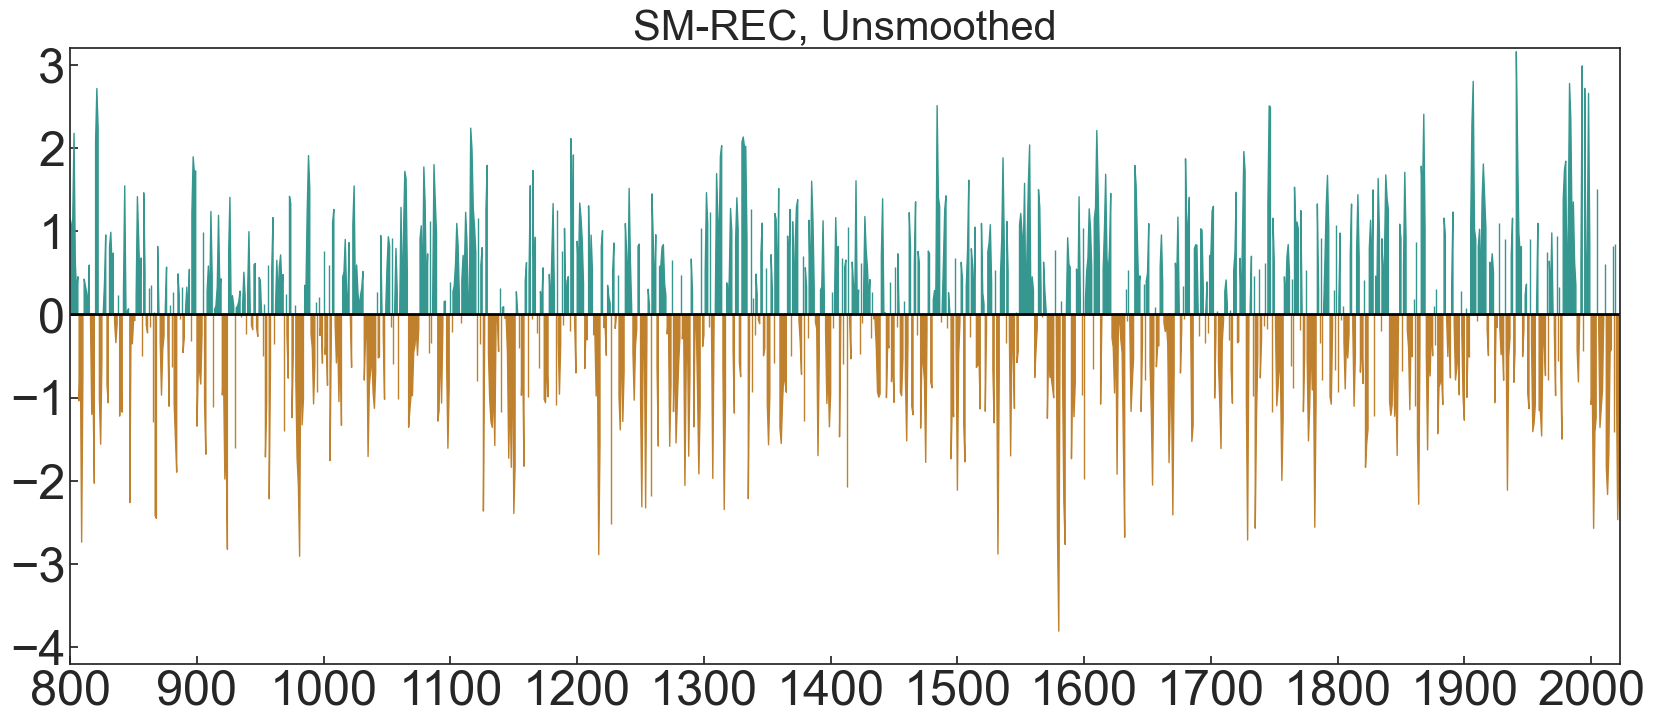

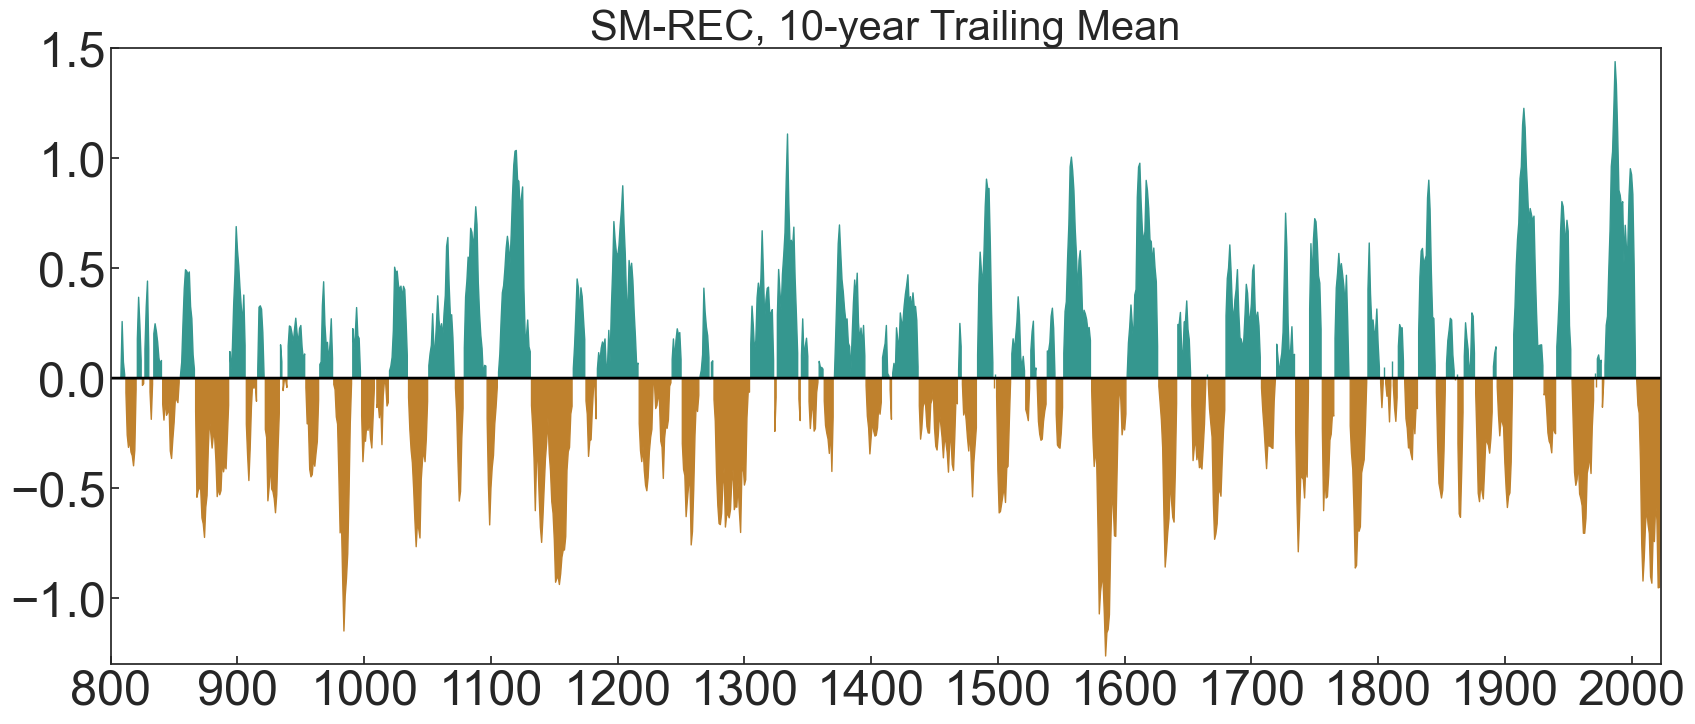

In [38]:
# Load into dataframe
pd_SMseries = pd.read_csv('../data/smrec/recon_2023.txt',delimiter=',')

# Pull out bias-corrected reconustruction and observational time series
sm_obs_yr = np.array(pd_SMseries['year'][:])
sm_obs_all = np.array(pd_SMseries['recon'][:])

# For zero line
y_zeros = np.zeros(sm_obs_yr.shape)

# Create Rolling Means of soil moisture
sm_5yr  = np.array(pd.Series(sm_obs_all).rolling(5).mean())
sm_10yr = np.array(pd.Series(sm_obs_all).rolling(10).mean())

# Replace NaN with zero values (only in the beginning, before the full moving averages can start)
# base data
i_miss5yr  = np.where(np.isnan(sm_5yr)==True)[0];   sm_5yr[i_miss5yr]   = 0;
i_miss10yr = np.where(np.isnan(sm_10yr)==True)[0];  sm_10yr[i_miss10yr] = 0

# Figure: unsmoothed
currplot=plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
#plt.fill_between(np.arange(2000,2020+1), -5, 4,color=[0.8,0.8,0.8], alpha=0.5,zorder=0)
plt.plot(sm_obs_yr,y_zeros,'-', color='k', linewidth=2)
#plt.plot(sm_obs_yr,sm_obs_all,color='k',linewidth=1)
# Shading
i_neg=sm_obs_all.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
i_pos=sm_obs_all.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
plt.fill_between(sm_obs_yr, y_zeros, sm_obs_all, where=i_neg, color='#bf812d', alpha=1)
plt.fill_between(sm_obs_yr, y_zeros, sm_obs_all, where=i_pos, color='#35978f', alpha=1)
plt.yticks([-4,-3,-2,-1,0,1,2,3,4],fontsize=35)
plt.xticks([800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000],fontsize=35)
plt.xlim(800,2023)
plt.ylim(-4.2,3.2)
plt.title('SM-REC, Unsmoothed')
#plt.savefig('../figures/sm200_recon_1yr_update_2023.pdf',format='pdf')
display(currplot)

# Figure: 10-year smoothed version
currplot=plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
#plt.fill_between(np.arange(2000,2020+1), -5, 4,color=[0.8,0.8,0.8], alpha=0.5,zorder=0)
plt.plot(sm_obs_yr,y_zeros,'-', color='k', linewidth=2)
#plt.plot(sm_obs_yr,sm_obs_all,color='k',linewidth=1)
# Shading
i_neg=sm_10yr.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
i_pos=sm_10yr.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
plt.fill_between(sm_obs_yr, y_zeros, sm_10yr, where=i_neg, color='#bf812d', alpha=1)
plt.fill_between(sm_obs_yr, y_zeros, sm_10yr, where=i_pos, color='#35978f', alpha=1)
plt.yticks([-1.0,-0.5,0,0.5,1.0,1.5],fontsize=35)
plt.xticks([800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000],fontsize=35)
plt.xlim(800,2023)
plt.ylim(-1.3,1.5)
plt.title('SM-REC, 10-year Trailing Mean')
#plt.savefig('../figures/sm200_recon_10yr_update_2023.pdf',format='pdf')
display(currplot)

# Close all plot instances
plt.close('all')


## Lat/Lon Range for Southwestern North America Region in PHYDA

In [39]:
# Lat/lon bounds
curr_latlon = np.array([-125,-105,30,45])


# Load PHYDA PDSI (v2)
* JJA Average PDSI (ensemble mean)

loading data...........
reducing precision...........
centering on greenwhich...........
creating land-sea mask...........


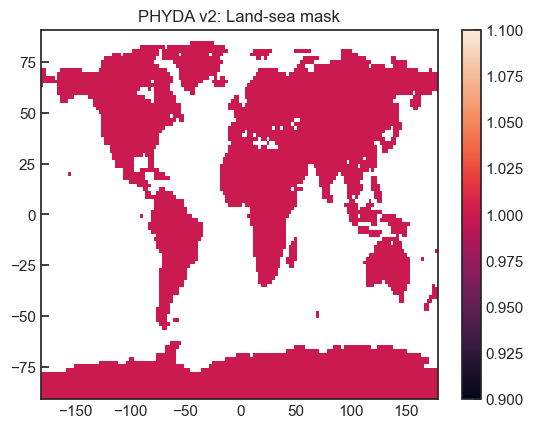

DONE


In [40]:
# Open Data File
print('loading data...........')
nc_file  = netCDF4.Dataset('../../../../GEODATA/PHYDA/v2/phyda_ens_pdsi_JunAug_r.1-2000_d.21-Nov-2018.nc')

# Load time, lat, lon data
lat_phy  = nc_file.variables['lat'][:]
lon_phy  = nc_file.variables['lon'][:]
yr_phy   = nc_file.variables['time'][:]

# Set time interval to pull for PHYDA (max overlap with Park's Recon
i_time   = np.nonzero(np.in1d(yr_phy,sm_obs_yr))[0]
yr_phy   = yr_phy[i_time].copy()

# Load PHYDA PDSI
pdsi_phy = nc_file.variables['pdsi_ens'][:,i_time,:,:]

# Close file
nc_file.close()

# Reduce precision to save memory
# np.round(-2.2119251403512905*1000)/1000
print('reducing precision...........')
pdsi_phy = np.round(pdsi_phy*1000)/1000

# Center on Greenwhich
print('centering on greenwhich...........')
lon_phy_shift  = lon_phy-180
i_west         = np.where(lon_phy>=180)[0]
i_east         = np.where(lon_phy<180)[0]
pdsi_phy_shift = np.concatenate((pdsi_phy[:,:,:,i_west],pdsi_phy[:,:,:,i_east]),axis=3)

# Create land-sea mask
print('creating land-sea mask...........')
lsmask_phy = np.sum(np.abs(pdsi_phy_shift),axis=(0,1))
lsmask_phy[lsmask_phy<=0] = np.nan
lsmask_phy[lsmask_phy>0]  = 1

currplot=plt.figure()
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1.5})
plt.pcolormesh(lon_phy_shift,lat_phy,lsmask_phy)
plt.colorbar()
plt.title('PHYDA v2: Land-sea mask')
display(currplot)

print('DONE')

# Close all plot instances
plt.close('all')

## Regional Area Weight Averaging

Text(0.5, 1.0, 'PHYDA v2: Regional Area Weighting Grid')

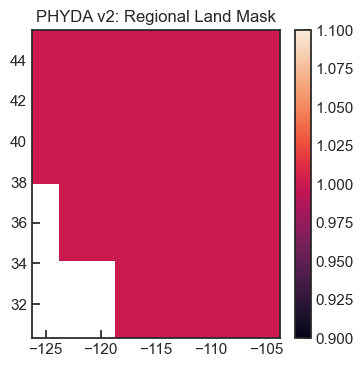

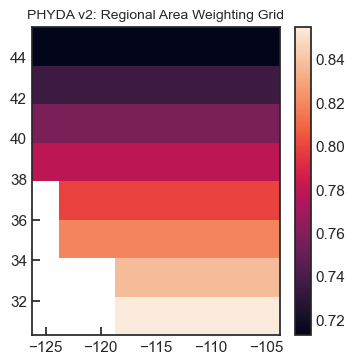

In [41]:
# Lat/lon locations for regions of interest------------------------------------------------------------------------------------------------------------
i_lat_SWNA = np.where( (lat_phy>=curr_latlon[2])       & (lat_phy<=curr_latlon[3]) )[0] 
i_lon_SWNA = np.where( (lon_phy_shift>=curr_latlon[0]) & (lon_phy_shift<=curr_latlon[1]) )[0]

# Latitudes and longitude for thisregions
lat_SWNA = lat_phy[i_lat_SWNA].copy(); lon_SWNA = lon_phy_shift[i_lon_SWNA].copy()

# Pull out ls mask to create area weightings
reg_area_SWNA = lsmask_phy[i_lat_SWNA,:][:,i_lon_SWNA].copy()
    
# Create Latitude Weights: WRU
lat_wts               = np.cos(np.deg2rad(lat_SWNA))
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_SWNA)
lat_wts_grid_SWNA     = np.swapaxes(lat_wts_grid,1,0)*reg_area_SWNA

plt.figure(figsize=(4,4))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1.5})
plt.pcolormesh(lon_SWNA,lat_SWNA,reg_area_SWNA)
plt.colorbar()
plt.title('PHYDA v2: Regional Land Mask')

plt.figure(figsize=(4,4))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1.5})
plt.pcolormesh(lon_SWNA,lat_SWNA,lat_wts_grid_SWNA)
plt.colorbar()
plt.title('PHYDA v2: Regional Area Weighting Grid',{'fontsize':10})


## Create Area Average Weighted SWNA PDSI Time Series

In [42]:
# Trim to Region
pdsi_phy_shift_SWNA = pdsi_phy_shift[:,:,i_lat_SWNA,:][:,:,:,i_lon_SWNA].copy()

# Apply the cosine area weighting (ensemble x year)
sm_swna_phy = np.nansum(pdsi_phy_shift_SWNA*lat_wts_grid_SWNA,axis=(2,3))/np.nansum(lat_wts_grid_SWNA)


## Compare SM-REC With PHYDA Ensemble Members

Text(0.5, 1.0, 'Pearson r, PHYDA Ens. Members/')

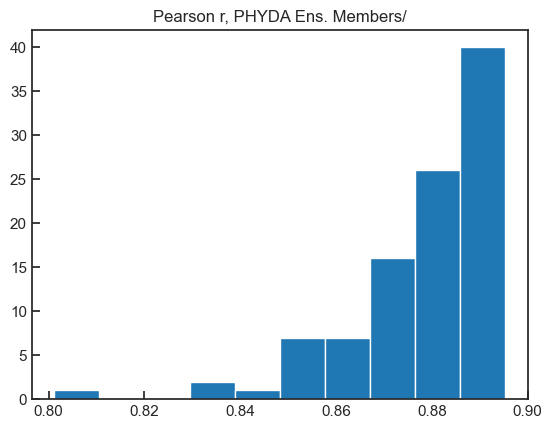

In [43]:
# Trim Park Recon for comparison
park_rec_trim = sm_obs_all[np.where(sm_obs_yr<=2000)].copy()

# Loop through each ensemble member and calculate correlation with Park's recon
corr_park_phyda_ens = np.zeros(100)*np.nan

# Ensemble loop for Correlation
for n_ens in np.arange(0,100):
    corr_park_phyda_ens[n_ens], pval = scipy.stats.pearsonr(park_rec_trim,sm_swna_phy[n_ens,:])

# Histogram of correlations
plt.figure()
plt.hist(corr_park_phyda_ens)
plt.title('Pearson r, PHYDA Ens. Members/')


## PHYDA: Standardize so that mean/variance match Park recon over overlapping period (800-2000)

Park Rec, 800-2000: n= (1201,)
PHYDA, 800-2000:    n= (100, 1201)


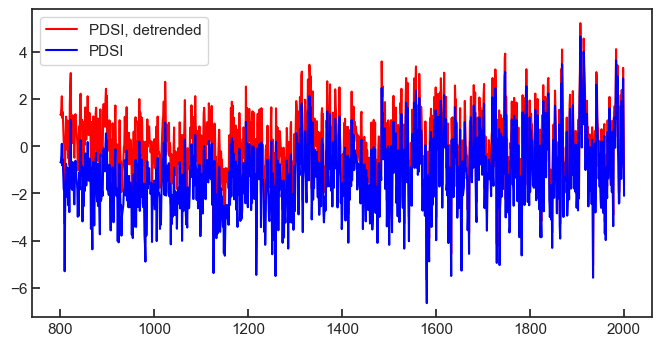

Park Rec, 800-2000:         mu= 0.015169915154038293 , sigma= 0.9913042071834637
PHYDA Restand., 800-2000:   mu= [0.015038 0.015038 0.015038 0.015038 0.015038]
PHYDA Restand., 800-2000:   sigma= [0.99130421 0.99130421 0.99130421 0.99130421 0.99130421]


In [44]:
# Check Shapes
print('Park Rec, 800-2000: n=', park_rec_trim.shape)
print('PHYDA, 800-2000:    n=', sm_swna_phy.shape)

# Detrend PHYDA First
sm_swna_phy_detrend = scipy.signal.detrend(sm_swna_phy,axis=1)

# Check detrending
n_ens = 30
currplot=plt.figure(figsize=(8,4))
plt.plot(yr_phy,sm_swna_phy_detrend[n_ens,:],color='r',label='PDSI, detrended')
plt.plot(yr_phy,sm_swna_phy[n_ens,:],color='b',label='PDSI')
plt.legend(loc=0)
display(currplot)

# Restandardize
sm_swna_phy_restd = scipy.stats.zscore(sm_swna_phy_detrend,axis=1)
sm_swna_phy_restd = sm_swna_phy_restd+np.mean(park_rec_trim)
sm_swna_phy_restd = sm_swna_phy_restd*np.std(park_rec_trim)

# Check Restandardization
print('Park Rec, 800-2000:         mu=', np.mean(park_rec_trim),', sigma=',np.std(park_rec_trim))
print('PHYDA Restand., 800-2000:   mu=', np.mean(sm_swna_phy_restd[0:5,:],axis=1))
print('PHYDA Restand., 800-2000:   sigma=',np.std(sm_swna_phy_restd[0:5,:],axis=1))

plt.close('all')

## Save PHYDA SWNA Soil Moisture for All Ensemble Members

In [45]:
# Column Names
cols_txt = []
cols_txt.append('Year')    
for n_col in np.arange(1,101):
    col_str = 'ens'+str(n_col)
    cols_txt.append(col_str)    

# Create Output Array
output_array = np.hstack(  (np.expand_dims(yr_phy,1),sm_swna_phy_restd.swapaxes(0,1)) )
    
# Initialize and Create Dataframe
df_out_phyda_pdsi = pd.DataFrame(columns=cols_txt,data=output_array,index=None)

# Save to csv file
df_out_phyda_pdsi.to_csv('../data/ensphyda/soilmoist/ensphyda_swna_pdsi_scaled_detrend.csv',index=False)
df_out_phyda_pdsi


,Year,ens1,ens2,ens3,ens4,ens5,ens6,ens7,ens8,ens9,...,ens91,ens92,ens93,ens94,ens95,ens96,ens97,ens98,ens99,ens100
0,800.0,0.984946,0.844407,0.876584,0.915280,0.826935,0.805939,0.829517,0.863968,0.867815,...,0.878090,0.901032,0.846757,0.771949,0.674879,0.853512,0.901147,0.863869,0.764129,0.982065
1,801.0,0.980858,0.832167,0.866084,0.902787,0.812489,0.790812,0.824703,0.859683,0.863105,...,0.857053,0.889942,0.839990,0.764802,0.660591,0.848196,0.893247,0.861286,0.759889,0.974440
2,802.0,1.193322,1.046420,1.079440,1.115692,1.024789,1.008524,1.036553,1.071904,1.077420,...,1.070540,1.106973,1.056200,0.978887,0.876821,1.064799,1.105530,1.075175,0.974383,1.187770
3,803.0,1.516535,1.379134,1.411695,1.448974,1.363000,1.342575,1.364669,1.399124,1.403148,...,1.411129,1.433671,1.383006,1.308910,1.210602,1.388907,1.432707,1.398215,1.300087,1.515100
4,804.0,0.890826,0.749979,0.783648,0.821409,0.735658,0.707635,0.738443,0.773020,0.774170,...,0.782935,0.801747,0.755488,0.680512,0.580113,0.757578,0.806466,0.770543,0.670642,0.889804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,1996.0,0.095640,0.045588,-0.083831,0.085305,0.205677,-0.034459,0.173067,0.065713,0.224554,...,-0.091224,-0.037820,0.055166,0.144623,0.258622,0.152341,0.059895,0.075071,0.021882,-0.004459
1197,1997.0,1.033065,0.949057,0.847209,1.014203,1.106842,0.878336,1.059994,0.988454,1.179961,...,0.811082,0.887096,1.001766,1.042199,1.119741,1.064774,1.023463,0.985093,0.964531,0.927944
1198,1998.0,2.645259,2.538066,2.437959,2.625934,2.659390,2.459602,2.651755,2.561629,2.769885,...,2.405879,2.459482,2.593237,2.680889,2.689002,2.655768,2.612984,2.607171,2.560336,2.499810
1199,1999.0,0.943725,0.717321,0.643617,0.981590,0.904793,0.724918,0.942811,0.770153,0.996342,...,0.657595,0.703370,0.776771,0.886889,0.917213,0.889464,0.883281,0.882278,0.772970,0.752303


## Loop through each ensemble member SWNA soil moisture, and calculate drought periods

In [47]:
# Ensemble loop
for n_col in np.arange(1,100+1):
    # Current Ensemble Member
    col_str = 'ens'+str(n_col)
    cols_txt.append(col_str)  
    
    # Set current soil moisture
    sm_obs_all = np.array(df_out_phyda_pdsi[col_str])

    # 10-year running mean
    sm_10yr = np.array(pd.Series(sm_obs_all).rolling(10).mean())

    # STEP #1A: FIND CONTINUOUS 5 YEAR DROUGHT PERIODS-----------------------------------------------------------------------------------------------------------
    # Indices for drought and pluvial years
    i_drght = np.where(sm_obs_all<0)[0]
    
    # Create list of contiguous drought/pluvial years
    contig_drght_yrs = group_consecutives(i_drght, step=1)
    
    # Initialize array for 5 year drought stats (first year, last year, length, cumsev)
    drought_stats_cont5yr = np.zeros((len(contig_drght_yrs),6))*np.nan
    
    # Loop through each drought event
    for n_drght in np.arange(0,len(contig_drght_yrs)):
        
        # Current drought indices
        i_curr_drght = contig_drght_yrs[n_drght].copy()
        
        # Years and values for current event
        yrs_curr_drght  = sm_obs_yr[i_curr_drght].copy()
        vals_curr_drght = sm_obs_all[i_curr_drght].copy()
        
        # Store drought stats
        drought_stats_cont5yr[n_drght,0] = np.min(yrs_curr_drght)
        drought_stats_cont5yr[n_drght,1] = np.max(yrs_curr_drght)
        drought_stats_cont5yr[n_drght,2] = np.size(yrs_curr_drght)
        drought_stats_cont5yr[n_drght,3] = np.where(vals_curr_drght>=0)[0].size
        drought_stats_cont5yr[n_drght,4] = np.mean(vals_curr_drght)
        drought_stats_cont5yr[n_drght,5] = np.sum(vals_curr_drght)
    
    # Trim to just events with at least five years
    i_5yr                    = np.where(drought_stats_cont5yr[:,2]>=5)[0]
    drought_stats_cont5yr    = drought_stats_cont5yr[i_5yr,:].copy()
    df_drought_stats_cont5yr = pd.DataFrame(data=drought_stats_cont5yr,columns=('FirstYr','LastYr','Duration','WetYrs','MeanAnom','CumSum'),index=None)
    #df_drought_stats_cont5yr

    # STEP #1B: FIND CONTINUOUS 5 YEAR PLUVIAL PERIODS-----------------------------------------------------------------------------------------------------------
    # Indices for drought and pluvial years
    i_pluv  = np.where(sm_obs_all>0)[0]
    
    # Create list of contiguous drought/pluvial years
    contig_pluv_yrs = group_consecutives(i_pluv, step=1)
    
    # Initialize array for 5 year drought stats (first year, last year, length, cumsev)
    pluvial_stats_cont5yr = np.zeros((len(contig_pluv_yrs),6))*np.nan
    
    # Loop through each drought event
    for n_pluv in np.arange(0,len(contig_pluv_yrs)):
        
        # Current drought indices
        i_curr_pluv = contig_pluv_yrs[n_pluv].copy()
        
        # Years and values for current event
        yrs_curr_pluv  = sm_obs_yr[i_curr_pluv].copy()
        vals_curr_pluv = sm_obs_all[i_curr_pluv].copy()
        
        # Store drought stats
        pluvial_stats_cont5yr[n_pluv,0] = np.min(yrs_curr_pluv)
        pluvial_stats_cont5yr[n_pluv,1] = np.max(yrs_curr_pluv)
        pluvial_stats_cont5yr[n_pluv,2] = np.size(yrs_curr_pluv)
        pluvial_stats_cont5yr[n_pluv,3] = np.where(vals_curr_pluv<=0)[0].size
        pluvial_stats_cont5yr[n_pluv,4] = np.mean(vals_curr_pluv)
        pluvial_stats_cont5yr[n_pluv,5] = np.sum(vals_curr_pluv)
    
    # Trim to just events with at least five years
    i_5yr                    = np.where(pluvial_stats_cont5yr[:,2]>=5)[0]
    pluvial_stats_cont5yr    = pluvial_stats_cont5yr[i_5yr,:].copy()
    df_pluvial_stats_cont5yr = pd.DataFrame(data=pluvial_stats_cont5yr,columns=('FirstYr','LastYr','Duration','DryYrs','MeanAnom','CumSum'),index=None)
    df_pluvial_stats_cont5yr
    
    # STEP #2A: FIND EXTENDED DROUGHTS, PARKS METHOD---------------------------------------------------------------------------------------------------------
    # Set paremeters for drought identification
    sm_txt    = 'phyda_drght_sm10yr';   # label
    sm_smooth = sm_10yr.copy();   # smoothed time series
    n_back    = 10-1;             # number of years for backtracking in drought algorithm
    n_min     = 10;               # minimum number of years for drought (to start with)
    
    # First, identify drought and non-drought years in smoothed time series
    i_drght       = np.where(sm_smooth<0)[0]
    i_nondrght    = np.where(sm_smooth>=0)[0]
    
    # Create binary series
    drght_binary = np.zeros(sm_obs_yr.shape)
    drght_binary[i_drght] = 1
    
    # Take first differences
    drghtbin_diff = np.diff(drght_binary)
    
    # 1: first year of drought, last year of drought (consecutive 5/10 year values under zero
    yr1_drght = sm_obs_yr[np.where(drghtbin_diff==1)]+1
    yr2_drght = sm_obs_yr[np.where(drghtbin_diff==-1)]
    
    # If last event is not over, use final year
    new_yr2 = np.expand_dims(sm_obs_yr[-1],axis=0)
    if yr2_drght.size<yr1_drght.size:
        yr2_drght = np.concatenate((yr2_drght,new_yr2))
    
    # Trim to decadal only events
    event_dur  = yr2_drght-yr1_drght+1
    i_valid    = np.where(event_dur>=n_min)
    yr1_drght  = yr1_drght[i_valid].copy()
    yr2_drght  = yr2_drght[i_valid].copy()
        
    # Storage Array for drought statistics: Yr1, Yr2, Duration, # dry years, Mean Anom., Cumulative Anomaly 
    drought_stats = np.zeros((yr1_drght.size,6))*np.nan
    
    # Backtracking to adjust yr1 and yr2. In loop, pull all years associated with window mean
    for loop_drght in enumerate(yr1_drght):
        n_drght = loop_drght[0]
        curr_yr1 = yr1_drght[n_drght].copy()
        curr_yr2 = yr2_drght[n_drght].copy()
    
        # Years associated with the calculate running means for curr_yr1 and curr_yr2
        allyears_yr1 = np.arange(curr_yr1-n_back,curr_yr1+1)
        allyears_yr2 = np.arange(curr_yr2-n_back,curr_yr2+1)
        
        # Maximum possible drought years
        max_drght_yrs = np.arange(np.min(allyears_yr1),np.max(allyears_yr2)+1) 
        
        # Pull out soil moisture values for these years
        i_max_yrs     = np.nonzero(np.in1d(sm_obs_yr,max_drght_yrs))[0]; 
        sm_drght_yrs  = sm_obs_all[i_max_yrs].copy();     
        
        # Pull out first and last n years
        sm_drght_first_n     = sm_drght_yrs[0:n_min].copy()
        sm_drght_last_n      = sm_drght_yrs[(-1*n_min):].copy()
        
        # RECALC FIRST DROUGHT YEAR
        end_drght  = 0
        drght_term = 0
        for n_y in enumerate(np.flip(sm_drght_first_n) ):
            #print(drght_term)
            # If the year is wet, accumulate end_drght counter
            if n_y[1]>=0:
                end_drght=end_drght+1
            # If year is dry, resent counter to zero
            if n_y[1]<0:
                end_drght=0
            # Once two wet years in a row, trigger drought termination
            if ( (drght_term==0) & (end_drght==2) ):
                drght_term = n_y       
            #print(end_drght)
                
        # First year of drought
        if drght_term==0:
            newyr1 = np.min(max_drght_yrs)
        else:  
            i_newyr1 = np.where(sm_drght_yrs==drght_term[1])[0]+2
            newyr1   = max_drght_yrs[i_newyr1]
        
        # RECALC LAST DROUGHT YEAR
        end_drght  = 0
        drght_term = 0
        for n_y in enumerate(sm_drght_last_n):
            # If the year is wet, accumulate end_drght counter
            if n_y[1]>=0:
                end_drght=end_drght+1
            # If year is dry, resent counter to zero
            if n_y[1]<0:
                end_drght=0
            # Once two wet years in a row, trigger drought termination
            if ( (drght_term==0) & (end_drght==2) ):
                drght_term = n_y
        # First year of drought
        if drght_term==0:
            newyr2 = np.max(max_drght_yrs)
        else:  
            i_newyr2 = np.where(sm_drght_yrs==drght_term[1])[0]-2
            newyr2   = max_drght_yrs[i_newyr2]
        
        # New Drought Info
        # using sum here to convert array to a scalar (even though just one element)
        new_drght_yrs = np.arange(np.sum(newyr1),np.sum(newyr2)+1)
        new_drght_sm  = sm_drght_yrs[np.nonzero(np.in1d(max_drght_yrs,new_drght_yrs))].copy()
           
        # Don't allow first or last years to be positive [JAN 2024]
        while new_drght_sm[0]>=0:
            new_drght_yrs = new_drght_yrs[1:].copy()
            new_drght_sm  = new_drght_sm[1:].copy()
        while new_drght_sm[-1]>=0:
            new_drght_yrs = new_drght_yrs[:-1].copy()
            new_drght_sm  = new_drght_sm[:-1].copy()
            
        # Store drought characteristics
        drought_stats[loop_drght[0],0] = np.min(new_drght_yrs)
        drought_stats[loop_drght[0],1] = np.max(new_drght_yrs)
        drought_stats[loop_drght[0],2] = np.size(new_drght_yrs)
        drought_stats[loop_drght[0],3] = np.where(new_drght_sm>=0)[0].size
        drought_stats[loop_drght[0],4] = np.mean(new_drght_sm)
        drought_stats[loop_drght[0],5] = np.sum(new_drght_sm)
        
    # Create Dataframe
    df_drought_stats = pd.DataFrame(data=drought_stats,columns=('FirstYr','LastYr','Duration','WetYrs','MeanAnom','CumSum'),index=None)
    
    # Remove events less than 5 years
    df_drght_williams = df_drought_stats[df_drought_stats['Duration']>=5]
    
    # Save to csv file
    #df_drght_williams.to_csv('../data/'+sm_txt+'_update.csv',index=False)
    df_drght_williams

    # STEP #2B: COMBINE EXTENDED AND 5-YEAR DROUGHT PERIODS-------------------------------------------------------------------------------------------------
        
    # Combine Dataframes of drought events
    df_drght_allposs = pd.concat([df_drght_williams, df_drought_stats_cont5yr], ignore_index=True)
    
    # Loop through each event and 
    first_yr = np.array(df_drght_allposs.sort_values('FirstYr',ascending=True).FirstYr)
    last_yr  = np.array(df_drght_allposs.sort_values('FirstYr',ascending=True).LastYr)
    
    # Loop through each event and build vectors of all continuous year
    for n_event in np.arange(0,first_yr.size):
    
        # If first, initialize array
        if n_event==0:
            drght_yrs_allposs = np.arange(first_yr[n_event],last_yr[n_event]+1)
        else:
            drght_yrs_allposs = np.hstack((drght_yrs_allposs,np.arange(first_yr[n_event],last_yr[n_event]+1)))
    
    # Just unique years and sort values
    drght_yrs_allposs = np.unique(np.sort(drght_yrs_allposs))
        
    # Find new unique continuous drought periods
    new_drght_yrs = group_consecutives(drght_yrs_allposs, step=1)
        
    # Loop through each drought event and recalculate stats
    drought_stats_final = np.zeros((len(new_drght_yrs),6))*np.nan
    
    for n_drght in np.arange(0,len(new_drght_yrs)):
        
        # Years, current drought and indices
        curr_drght_yrs = new_drght_yrs[n_drght].copy()
        i_curr_drght    = np.nonzero(np.in1d(sm_obs_yr,curr_drght_yrs))[0]
    
        # Years and values for current event
        yrs_curr_drght  = sm_obs_yr[i_curr_drght].copy()
        vals_curr_drght = sm_obs_all[i_curr_drght].copy()
        
        # Store drought stats
        drought_stats_final[n_drght,0] = np.min(yrs_curr_drght)
        drought_stats_final[n_drght,1] = np.max(yrs_curr_drght)
        drought_stats_final[n_drght,2] = np.size(yrs_curr_drght)
        drought_stats_final[n_drght,3] = np.where(vals_curr_drght>=0)[0].size
        drought_stats_final[n_drght,4] = np.mean(vals_curr_drght)
        drought_stats_final[n_drght,5] = np.sum(vals_curr_drght)
        
    # Create Dataframe
    df_drought_stats_final = pd.DataFrame(data=drought_stats_final,columns=('FirstYr','LastYr','Duration','WetYrs','MeanAnom','CumSum'),index=None)
    
    # Save to csv file (just for testing)
    #df_drought_stats_final.to_csv('../data/'+sm_txt+'_update_2023.csv',index=False)
    #df_drought_stats_final
    
    # STEP #3A: FIND EXTENDED PLUVIALS, PARKS METHOD---------------------------------------------------------------------------------------------------------
    # Set paremeters for drought identification
    sm_txt    = 'phyda_pluv_sm10yr';   # label
    sm_smooth = sm_10yr.copy();   # smoothed time series
    n_back    = 10-1;             # number of years for backtracking in drought algorithm
    n_min     = 10;               # minimum number of years for drought (to start with)
    
    # First, identify drought and non-drought years in smoothed time series
    i_drght       = np.where(sm_smooth<0)[0]
    i_nondrght    = np.where(sm_smooth>0)[0]
    
    # Create binary series
    drght_binary = np.zeros(sm_obs_yr.shape)
    drght_binary[i_nondrght] = 1
    
    # Take first differences
    drghtbin_diff = np.diff(drght_binary)
    
    # 1: first year of pluvial, last year of pluvial (consecutive 5/10 year values under zero
    yr1_pluv = sm_obs_yr[np.where(drghtbin_diff==1)]+1
    yr2_pluv = sm_obs_yr[np.where(drghtbin_diff==-1)]
    
    # If last event is not over, use final year
    new_yr2 = np.expand_dims(sm_obs_yr[-1],axis=0)
    if yr2_pluv.size<yr1_pluv.size:
        yr2_pluv = np.concatenate((yr2_pluv,new_yr2))
    
    # Trim to decadal only events
    event_dur  = yr2_pluv-yr1_pluv+1
    i_valid    = np.where(event_dur>=n_min)
    yr1_pluv  = yr1_pluv[i_valid].copy()
    yr2_pluv  = yr2_pluv[i_valid].copy()
    
    # Storage Array for drought statistics: Yr1, Yr2, Duration, # dry years, Mean Anom., Cumulative Anomaly 
    pluv_stats = np.zeros((yr1_pluv.size,6))*np.nan
    
    # Backtracking to adjust yr1 and yr2. In loop, pull all years associated with window mean
    for loop_drght in enumerate(yr1_pluv):
        n_drght = loop_drght[0]
        curr_yr1 = yr1_pluv[n_drght]
        curr_yr2 = yr2_pluv[n_drght]
        
        # Years associated with the calculate running means for curr_yr1 and curr_yr2
        allyears_yr1 = np.arange(curr_yr1-n_back,curr_yr1+1)
        allyears_yr2 = np.arange(curr_yr2-n_back,curr_yr2+1)
        
        # Maximum possible pluvial years
        max_pluv_yrs = np.arange(np.min(allyears_yr1),np.max(allyears_yr2)+1) 
        
        # Pull out soil moisture values for these years
        i_max_yrs    = np.nonzero(np.in1d(sm_obs_yr,max_pluv_yrs))[0]; 
        sm_pluv_yrs  = sm_obs_all[i_max_yrs].copy();     
        
        # Pull out first and last n years
        sm_pluv_first_n     = sm_pluv_yrs[0:n_min].copy()
        sm_pluv_last_n      = sm_pluv_yrs[(-1*n_min):].copy()
    
        # RECALC FIRST PLUVIAL YEAR
        end_pluv  = 0
        pluv_term = 0
        for n_y in enumerate(np.flip(sm_pluv_first_n) ):
            #print(drght_term)
            # If the year is wet, accumulate end_drght counter
            if n_y[1]<0:
                end_pluv=end_pluv+1
            # If year is dry, resent counter to zero
            if n_y[1]>0:
                end_pluv=0
            # Once two wet years in a row, trigger drought termination
            if ( (pluv_term==0) & (end_pluv==2) ):
                pluv_term = n_y       
        # First year of pluvial
        if pluv_term==0:
            newyr1 = np.min(max_pluv_yrs)
        else:  
            i_newyr1 = np.where(sm_pluv_yrs==pluv_term[1])[0]+2
            newyr1   = max_pluv_yrs[i_newyr1]
        
        # RECALC LAST PLUVIAL YEAR
        end_pluv  = 0
        pluv_term = 0
        for n_y in enumerate(sm_pluv_last_n):
            # If the year is wet, accumulate end_drght counter
            if n_y[1]<0:
                end_pluv=end_pluv+1
            # If year is dry, reset counter to zero
            if n_y[1]>0:
                end_pluv=0
            # Once two wet years in a row, trigger drought termination
            if ( (pluv_term==0) & (end_pluv==2) ):
                pluv_term = n_y
        # First year of drought
        if pluv_term==0:
            newyr2 = np.max(max_pluv_yrs)
        else:  
            i_newyr2 = np.where(sm_pluv_yrs==pluv_term[1])[0]-2
            newyr2   = max_pluv_yrs[i_newyr2]
        
        # New Drought Info
        # using sum here to convert array to a scalar (even though just one element)
        new_pluv_yrs = np.arange(np.sum(newyr1),np.sum(newyr2)+1)
        new_pluv_sm  = sm_pluv_yrs[np.nonzero(np.in1d(max_pluv_yrs,new_pluv_yrs))].copy()
    
        # Don't allow first or last years to be negative [JAN 2024]
        while new_pluv_sm[0]<=0:
            new_pluv_yrs = new_pluv_yrs[1:].copy()
            new_pluv_sm  = new_pluv_sm[1:].copy()
        while new_pluv_sm[-1]<=0:
            new_pluv_yrs = new_pluv_yrs[:-1].copy()
            new_pluv_sm  = new_pluv_sm[:-1].copy()
    
        # Store drought characteristics
        pluv_stats[loop_drght[0],0] = np.min(new_pluv_yrs)
        pluv_stats[loop_drght[0],1] = np.max(new_pluv_yrs)
        pluv_stats[loop_drght[0],2] = np.size(new_pluv_yrs)
        pluv_stats[loop_drght[0],3] = np.where(new_pluv_sm<0)[0].size
        pluv_stats[loop_drght[0],4] = np.mean(new_pluv_sm)
        pluv_stats[loop_drght[0],5] = np.sum(new_pluv_sm)
        
    # Create Dataframe
    df_pluv_stats = pd.DataFrame(data=pluv_stats,columns=('FirstYr','LastYr','Duration','DryYrs','MeanAnom','CumSum'),index=None)
    
    # Remove events less than 5 years
    df_pluv_williams = df_pluv_stats[df_pluv_stats['Duration']>=5]
    
    # Save to csv file
    #df_pluv_williams.to_csv('../data/'+sm_txt+'.csv',index=False)
    df_pluv_williams
    #df_pluv_williams.sort_values('Duration',ascending=False)
    #df_drght_williams.sort_values('CumSum',ascending=True)
    
    # STEP #3B: COMBINE EXTENDED AND 5-YEAR PLUVIAL PERIODS-------------------------------------------------------------------------------------------------
    # Combine Dataframes of drought events
    df_pluv_allposs = pd.concat([df_pluv_williams, df_pluvial_stats_cont5yr], ignore_index=True)
    
    # Loop through each event and 
    first_yr = np.array(df_pluv_allposs.sort_values('FirstYr',ascending=True).FirstYr)
    last_yr  = np.array(df_pluv_allposs.sort_values('FirstYr',ascending=True).LastYr)
    
    # Loop through each event and build vectors of all continuous year
    for n_event in np.arange(0,first_yr.size):
    
        # If first, initialize array
        if n_event==0:
            pluv_yrs_allposs = np.arange(first_yr[n_event],last_yr[n_event]+1)
        else:
            pluv_yrs_allposs = np.hstack((pluv_yrs_allposs,np.arange(first_yr[n_event],last_yr[n_event]+1)))
    
    # Just unique years and sort values
    pluv_yrs_allposs = np.unique(np.sort(pluv_yrs_allposs))
        
    # Find new unique continuous drought periods
    new_pluv_yrs = group_consecutives(pluv_yrs_allposs, step=1)       
               
    # Loop through each drought event and recalculate stats
    pluvial_stats_final = np.zeros((len(new_pluv_yrs),6))*np.nan
    
    for n_pluv in np.arange(0,len(new_pluv_yrs)):
        
        # Years, current drought and indices
        curr_pluv_yrs = new_pluv_yrs[n_pluv].copy()
        i_curr_pluv    = np.nonzero(np.in1d(sm_obs_yr,curr_pluv_yrs))[0]
    
        # Years and values for current event
        yrs_curr_pluv  = sm_obs_yr[i_curr_pluv].copy()
        vals_curr_pluv = sm_obs_all[i_curr_pluv].copy()
        
        # Store drought stats
        pluvial_stats_final[n_pluv,0] = np.min(yrs_curr_pluv)
        pluvial_stats_final[n_pluv,1] = np.max(yrs_curr_pluv)
        pluvial_stats_final[n_pluv,2] = np.size(yrs_curr_pluv)
        pluvial_stats_final[n_pluv,3] = np.where(vals_curr_pluv<=0)[0].size
        pluvial_stats_final[n_pluv,4] = np.mean(vals_curr_pluv)
        pluvial_stats_final[n_pluv,5] = np.sum(vals_curr_pluv)
        
    # Create Dataframe
    df_pluvial_stats_final = pd.DataFrame(data=pluvial_stats_final,columns=('FirstYr','LastYr','Duration','DryYrs','MeanAnom','CumSum'),index=None)
    
    # Save to csv file (just for testing)
    #df_pluvial_stats_final.to_csv('../data/'+sm_txt+'_update_2023.csv',index=False)
    #df_pluvial_stats_final
    #df_pluvial_stats_final.sort_values('Duration',ascending=False)
    #df_pluvial_stats_final.sort_values('CumSum',ascending=False)

    # STEP #4A: Check for Overlapping Drought/Pluvial Years-------------------------------------------------------------------------------------------------
    df_pluvial_stats_final2 = copy.deepcopy(df_pluvial_stats_final)
    df_drought_stats_final2 = copy.deepcopy(df_drought_stats_final)
    
    # Pull out list of first and last year of pluvial events
    pluv_yrbeg  = np.array(df_pluvial_stats_final.FirstYr)
    pluv_yrend  = np.array(df_pluvial_stats_final.LastYr)
    pluv_yrterm = pluv_yrend+1
    
    # Loop through pluvial events
    for n_pluv in np.arange(0,pluv_yrbeg.size):  
        # All years, current pluvial
        currpluv_yrs = np.arange(pluv_yrbeg[n_pluv],pluv_yrend[n_pluv]+1)
    
        # If first event, use this to initialize all years array
        if n_pluv==0:
            allpluv_yrs = currpluv_yrs.copy()
        # Otherwise, append
        else:
            allpluv_yrs = np.hstack((allpluv_yrs,currpluv_yrs))
        
    #print('# extended pluvial years =',np.size(allpluv_yrs))
    
    # Pull out list of first and last year of drought events
    drgt_yrbeg = np.array(df_drought_stats_final.FirstYr)
    drgt_yrend = np.array(df_drought_stats_final.LastYr)
    drgt_yrterm = drgt_yrend+1
    
    # Loop through pluvial events
    for n_drgt in np.arange(0,drgt_yrbeg.size):  
        # All years, current pluvial
        currdrgt_yrs = np.arange(drgt_yrbeg[n_drgt],drgt_yrend[n_drgt]+1)
    
        # If first event, use this to initialize all years array
        if n_drgt==0:
            alldrgt_yrs = currdrgt_yrs.copy()
        # Otherwise, append
        else:
            alldrgt_yrs = np.hstack((alldrgt_yrs,currdrgt_yrs))
        
    
    # Years that don't fall within the extended droughts or pluvials
    allother_yrs = np.setxor1d(yr_phy,np.hstack((alldrgt_yrs,allpluv_yrs)))
    
    # Overlapping Years
    overlap_yrs = np.intersect1d(alldrgt_yrs,allpluv_yrs)
    n_ov1 = np.size(overlap_yrs)
    #print('# extended drought years =',np.size(alldrgt_yrs))
    #print('# other years =',np.size(allother_yrs))
    #
    #print('# SUM =',np.size(allother_yrs)+np.size(alldrgt_yrs)+np.size(allpluv_yrs))
    #print('# TOTAL YEARS =',yr_phy.size)
    #    
    #print('')
    #print('Overlapping Years: ',overlap_yrs)
    #print(overlap_yrs)

    # STEP #4B: take mean of overlapping years: if positive, assign to pluvial // if negative assign to drought----------------------------------------------------------------------------------
    # Separate out into discrete events
    overlap_events = group_consecutives(overlap_yrs, step=1)
    
    # Loop through each overlapping events
    for n_over in np.arange(0,len(overlap_events)):
        curr_over_yrs = np.array(overlap_events[n_over])
        #print(curr_over_yrs)
        
        # Pull out soil moisture values for this interview
        i_over  = np.nonzero(np.in1d(sm_obs_yr,curr_over_yrs))[0]
        sm_over = np.mean(sm_obs_all[i_over])
    
        # print('Overlapping Soil Moisture Anomaly: ',sm_over)
    
        # If positive, assign to pluvial; if negative assign to drought
        # positive
        if sm_over>0:
            # Loop through drought events; find overlap and remove these years
            for n_d in np.arange(0,drgt_yrbeg.size):  
                currdrgt_yrs = np.arange(drgt_yrbeg[n_d],drgt_yrend[n_d]+1)
    
                # For the overlapping event
                if np.nonzero(np.in1d(currdrgt_yrs,curr_over_yrs))[0].size>0:
                    # Remove years and recalculate statistics
                    new_yrs = currdrgt_yrs[np.in1d(currdrgt_yrs,curr_over_yrs,invert=True)].copy()
                    # print('Wet, so trim drought to:')
                    # print(new_yrs)
                    # print(' ')
                    # print(n_drgt)
                    
                    # Pull out soil moisture data for these years
                    sm_new = sm_obs_all[np.nonzero(np.in1d(sm_obs_yr,new_yrs))[0]]
    
                    # Don't allow first or last years to be negative [JAN 2024]
                    while sm_new[0]>=0:
                        new_yrs = new_yrs[1:].copy()
                        sm_new  = sm_new[1:].copy()
                    while sm_new[-1]>=0:
                        new_yrs = new_yrs[:-1].copy()
                        sm_new  = sm_new[:-1].copy()
                    
                    # Assign new values
                    #df_drought_stats_final2.iloc[n_d]['FirstYr']  = np.min(new_yrs)
                    #df_drought_stats_final2.iloc[n_d]['LastYr']   = np.max(new_yrs)
                    #df_drought_stats_final2.iloc[n_d]['Duration'] = np.size(new_yrs)
                    #df_drought_stats_final2.iloc[n_d]['WetYrs']   = np.where(sm_new>0)[0].size
                    #df_drought_stats_final2.iloc[n_d]['MeanAnom'] = np.mean(sm_new)
                    #df_drought_stats_final2.iloc[n_d]['CumSum']   = np.sum(sm_new)
                    df_drought_stats_final2.loc[n_d,'FirstYr']  = np.min(new_yrs)
                    df_drought_stats_final2.loc[n_d,'LastYr']   = np.max(new_yrs)
                    df_drought_stats_final2.loc[n_d,'Duration'] = np.size(new_yrs)
                    df_drought_stats_final2.loc[n_d,'WetYrs']   = np.where(sm_new>0)[0].size
                    df_drought_stats_final2.loc[n_d,'MeanAnom'] = np.mean(sm_new)
                    df_drought_stats_final2.loc[n_d,'CumSum']   = np.sum(sm_new)
                    
                    drgt_yrbeg[n_d]=np.min(new_yrs)
                    drgt_yrend[n_d]=np.max(new_yrs)
        # negative
        if sm_over<0:
            # Loop through drought events; find overlap and remove these years
            for n_p in np.arange(0,pluv_yrbeg.size):  
                currpluv_yrs = np.arange(pluv_yrbeg[n_p],pluv_yrend[n_p]+1)
                # print(currpluv_yrs)
    
                # For the overlapping event
                if np.nonzero(np.in1d(currpluv_yrs,curr_over_yrs))[0].size>0:
                    # Remove years and recalculate statistics
                    new_yrs = currpluv_yrs[np.in1d(currpluv_yrs,curr_over_yrs,invert=True)].copy()
                    # print('Dry, so trim pluvial to:')
                    # print(new_yrs)
                    # print(' ')
    
                    # Pull out soil moisture data for these years
                    sm_new = sm_obs_all[np.nonzero(np.in1d(sm_obs_yr,new_yrs))[0]]
    
                    # Don't allow first or last years to be negative [JAN 2024]
                    while sm_new[0]<=0:
                        new_yrs = new_yrs[1:].copy()
                        sm_new  = sm_new[1:].copy()
                    while sm_new[-1]<=0:
                        new_yrs = new_yrs[:-1].copy()
                        sm_new  = sm_new[:-1].copy()
                    
                    # Assign new values
                    #df_pluvial_stats_final2.iloc[n_p]['FirstYr']  = np.min(new_yrs)
                    #df_pluvial_stats_final2.iloc[n_p]['LastYr']   = np.max(new_yrs)
                    #df_pluvial_stats_final2.iloc[n_p]['Duration'] = np.size(new_yrs)
                    #df_pluvial_stats_final2.iloc[n_p]['DryYrs']   = np.where(sm_new<0)[0].size
                    #df_pluvial_stats_final2.iloc[n_p]['MeanAnom'] = np.mean(sm_new)
                    #df_pluvial_stats_final2.iloc[n_p]['CumSum']   = np.sum(sm_new)
                    df_pluvial_stats_final2.loc[n_p,'FirstYr']  = np.min(new_yrs)
                    df_pluvial_stats_final2.loc[n_p,'LastYr']   = np.max(new_yrs)
                    df_pluvial_stats_final2.loc[n_p,'Duration'] = np.size(new_yrs)
                    df_pluvial_stats_final2.loc[n_p,'DryYrs']   = np.where(sm_new<0)[0].size
                    df_pluvial_stats_final2.loc[n_p,'MeanAnom'] = np.mean(sm_new)
                    df_pluvial_stats_final2.loc[n_p,'CumSum']   = np.sum(sm_new)
                    
                    pluv_yrbeg[n_p]=np.min(new_yrs)
                    pluv_yrend[n_p]=np.max(new_yrs)
    
    # Remove any events less than five years
    df_drought_stats_final2 = df_drought_stats_final2[df_drought_stats_final2['Duration']>=5]
    df_pluvial_stats_final2 = df_pluvial_stats_final2[df_pluvial_stats_final2['Duration']>=5]
    
    # Final check for overlapping years
    pluv_yrbeg  = np.array(df_pluvial_stats_final2.FirstYr)
    pluv_yrend  = np.array(df_pluvial_stats_final2.LastYr)
    pluv_yrterm = pluv_yrend+1
    # Loop through pluvial events
    for n_pluv in np.arange(0,pluv_yrbeg.size):  
        # All years, current pluvial
        currpluv_yrs = np.arange(pluv_yrbeg[n_pluv],pluv_yrend[n_pluv]+1)
        # If first event, use this to initialize all years array
        if n_pluv==0:
            allpluv_yrs = currpluv_yrs.copy()
        # Otherwise, append
        else:
            allpluv_yrs = np.hstack((allpluv_yrs,currpluv_yrs))        
    # Pull out list of first and last year of drought events
    drgt_yrbeg = np.array(df_drought_stats_final2.FirstYr)
    drgt_yrend = np.array(df_drought_stats_final2.LastYr)
    drgt_yrterm = drgt_yrend+1
    
    # Loop through pluvial events
    for n_drgt in np.arange(0,drgt_yrbeg.size):  
        # All years, current pluvial
        currdrgt_yrs = np.arange(drgt_yrbeg[n_drgt],drgt_yrend[n_drgt]+1)
        # If first event, use this to initialize all years array
        if n_drgt==0:
            alldrgt_yrs = currdrgt_yrs.copy()
        # Otherwise, append
        else:
            alldrgt_yrs = np.hstack((alldrgt_yrs,currdrgt_yrs))
    # Years that don't fall within the extended droughts or pluvials
    allother_yrs = np.setxor1d(yr_phy,np.hstack((alldrgt_yrs,allpluv_yrs)))
    # Overlapping Years
    overlap_yrs = np.intersect1d(alldrgt_yrs,allpluv_yrs)
    n_ov2 = np.size(overlap_yrs)
    print('ens #'+str(n_col)+': '+str(n_ov1)+' ,'+str(n_ov2))
    
    # STEP #5: SAVE DROUGHT AND PLUVIAL STATISTICS---------------------------------------------------------------------------------------------------
    
    # Drought
    df_drought_stats_final2.to_csv('../data/ensphyda/statsdrght/phyda_ens#'+str(n_col)+'_extdrght.csv',index=False)

    # Pluvial
    df_pluvial_stats_final2.to_csv('../data/ensphyda/statspluv/phyda_ens#'+str(n_col)+'_extpluv.csv',index=False)
    

ens #1: 16 ,0
ens #2: 18 ,0
ens #3: 18 ,0
ens #4: 16 ,0
ens #5: 18 ,0
ens #6: 18 ,0
ens #7: 18 ,0
ens #8: 18 ,0
ens #9: 18 ,0
ens #10: 18 ,0
ens #11: 18 ,0
ens #12: 18 ,0
ens #13: 16 ,0
ens #14: 20 ,0
ens #15: 16 ,0
ens #16: 16 ,0
ens #17: 20 ,0
ens #18: 18 ,0
ens #19: 18 ,0
ens #20: 18 ,0
ens #21: 14 ,0
ens #22: 16 ,0
ens #23: 18 ,0
ens #24: 18 ,0
ens #25: 16 ,0
ens #26: 16 ,0
ens #27: 18 ,0
ens #28: 14 ,0
ens #29: 22 ,0
ens #30: 16 ,0
ens #31: 24 ,0
ens #32: 14 ,0
ens #33: 20 ,0
ens #34: 18 ,0
ens #35: 18 ,0
ens #36: 16 ,0
ens #37: 22 ,0
ens #38: 16 ,0
ens #39: 14 ,0
ens #40: 14 ,0
ens #41: 16 ,0
ens #42: 18 ,0
ens #43: 18 ,0
ens #44: 18 ,0
ens #45: 14 ,0
ens #46: 16 ,0
ens #47: 18 ,0
ens #48: 24 ,0
ens #49: 16 ,0
ens #50: 18 ,0
ens #51: 16 ,0
ens #52: 14 ,0
ens #53: 18 ,0
ens #54: 16 ,0
ens #55: 18 ,0
ens #56: 16 ,0
ens #57: 8 ,0
ens #58: 18 ,0
ens #59: 16 ,0
ens #60: 18 ,0
ens #61: 18 ,0
ens #62: 18 ,0
ens #63: 12 ,0
ens #64: 16 ,0
ens #65: 22 ,0
ens #66: 18 ,0
ens #67: 20 ,0
ens #